# Assignment 2 - Machine Learning
**Project:** Project 1 - Classify Images of Road Traffic Signs

**Group Name:** Dan & Ethan
| Name               | Student Number |
|--------------------|----------------|
| Daniel Schellekens | s3900792       |
| Ethan Rayner       | s3902240       |

In [1]:
TEST_TRAIN_SPLIT = 0.5

import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("images.csv")

train_data, val_data = train_test_split(
    data, 
    test_size = TEST_TRAIN_SPLIT, 
    random_state = 0)

print(
    "Test set: {} rows\nValidation set: {} rows"
    .format(train_data.shape[0], val_data.shape[0]))

data.head()

Test set: 1849 rows
Validation set: 1850 rows


,path,shape,type
0,images\diamond\rightofway\00032_00000.png,diamond,rightofway
1,images\diamond\rightofway\00032_00001.png,diamond,rightofway
2,images\diamond\rightofway\00032_00002.png,diamond,rightofway
3,images\diamond\rightofway\00037_00000.png,diamond,rightofway
4,images\diamond\rightofway\00037_00001.png,diamond,rightofway


In [2]:
BATCH_SIZE = 32
PATH_COLUMN = "path"
CLASS_COLUMN = "type"
NUM_OF_CLASSES = len(pd.unique(data[CLASS_COLUMN]))

# This defaults to 256x256 probably to account for super large images,
# but since our images are only 28x28 there's probably no point upscaling them, 
# right?
IMAGE_SIZE = 28 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    brightness_range = [0.5, 1.5])
    
val_datagen = ImageDataGenerator(
    rotation_range = 15, 
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    brightness_range = [0.5, 1.5])

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_data,
    directory = "./",
    x_col = PATH_COLUMN,
    y_col = CLASS_COLUMN,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical") # categorical mode only works with one-hot encoding?

val_generator = val_datagen.flow_from_dataframe(
    dataframe = val_data,
    directory = "./",
    x_col = PATH_COLUMN,
    y_col = CLASS_COLUMN,
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "categorical") # categorical mode only works with one-hot encoding?

Found 1849 validated image filenames belonging to 16 classes.
Found 1850 validated image filenames belonging to 16 classes.


In [3]:
import matplotlib.pyplot as plt

def plot_learning_curve(
    train_loss, 
    val_loss, 
    train_metric, 
    val_metric, 
    metric_name = "Accuracy"):

    plt.figure(figsize = (10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, "r--")
    plt.plot(val_loss, "b--")
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(["train", "val"], loc = "upper left")

    plt.subplot(1, 2, 2)
    plt.plot(train_metric, "r--")
    plt.plot(val_metric, "b--")
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(["train", "val"], loc = "upper left")

    plt.show()

In [4]:
import tensorflow as tf

model_VGG_3x3 = tf.keras.Sequential([
    # VGG block 1
    tf.keras.layers.Conv2D(
        IMAGE_SIZE, 
        (3, 3), 
        activation = "relu", 
        padding = "same", 

        # Is this 3 for RGB? Because our images are only B+W...
        input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),
    
    tf.keras.layers.Conv2D(
        IMAGE_SIZE, 
        (3, 3), 
        activation = "relu", 
        padding = "same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # VGG block 2
    tf.keras.layers.Conv2D(
        IMAGE_SIZE * 2, 
        (3, 3), 
        activation = "relu", 
        padding = "same"),
    tf.keras.layers.Conv2D(
        IMAGE_SIZE * 2, 
        (3, 3), 
        activation = "relu", 
        padding = "same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # VGG block 3
    tf.keras.layers.Conv2D(
        IMAGE_SIZE * 4, 
        (3, 3), 
        activation = "relu", 
        padding = "same"),
    tf.keras.layers.Conv2D(
        IMAGE_SIZE * 4, 
        (3, 3), 
        activation = "relu", 
        padding = "same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(IMAGE_SIZE * 4, activation = "relu"),
    tf.keras.layers.Dense(NUM_OF_CLASSES),
])

In [5]:
model_VGG_3x3.compile(
    optimizer = "adam",
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics = ["categorical_accuracy"])

In [6]:
# After about 20 epochs things seem to stabilize
EPOCHS = 30

history_VGG_3x3 = model_VGG_3x3.fit(
    train_generator,
    validation_data = val_generator, 
    epochs = EPOCHS, 
    verbose = 0)

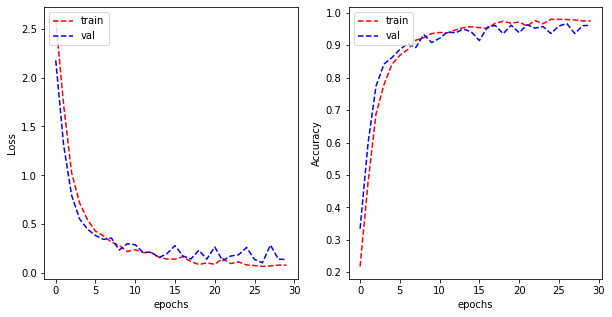

In [7]:
plot_learning_curve(
    history_VGG_3x3.history["loss"], 
    history_VGG_3x3.history["val_loss"], 
    history_VGG_3x3.history["categorical_accuracy"], 
    history_VGG_3x3.history["val_categorical_accuracy"], 
    metric_name = "Accuracy")